In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.linear_model as sklm
import sklearn.cross_validation as skcv
import sklearn.feature_selection as skfs
import sklearn.ensemble as skes
import sys
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

Data Preprocessing
------

In [182]:
df_raw = pd.read_csv("parser_silver.csv")
print(len(df_raw))
df = df_raw[df_raw['gold10'].isnull() == False]
print(len(df))

119720
119720


In [183]:
def list_str(str):
    return json.loads(str)
df['allyChampList'] = df['allyChampions'].apply(list_str)
df['opponentChampList'] = df['opponentChampions'].apply(list_str)
df['item10List'] = df['items10'].apply(list_str)

In [184]:
champ_ids = df['championId'].unique()
champ_ids.sort()
base_cols = []

for c_id in champ_ids:
    sys.stdout.write("{0},".format(c_id))
    allyc_col = "allyc_{0}".format(c_id)
    oppc_col = "opponentc_{0}".format(c_id)
    df[allyc_col] = df['allyChampList'].map(lambda x: c_id in x)
    df[oppc_col] = df['opponentChampList'].map(lambda x: c_id in x)
    base_cols.append(allyc_col)
    base_cols.append(oppc_col)
print(len(champ_ids))

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,48,50,51,53,54,55,56,57,58,59,60,61,62,63,64,67,68,69,72,74,75,76,77,78,79,80,81,82,83,84,85,86,89,90,91,92,96,98,99,101,102,103,104,105,106,107,110,111,112,113,114,115,117,119,120,121,122,126,127,131,133,134,143,150,154,157,161,201,203,222,223,236,238,245,254,266,267,268,412,420,421,429,432,128


In [185]:
print(len(champ_ids))

128


In [186]:
df['lanerole'] = df['lane'] + df['role']
lroles = df['lanerole'].unique()
for lrole in lroles:
    lrole_col = "lr_{0}".format(lrole)
    df[lrole_col] = (df['lanerole'] == lrole)
    base_cols.append(lrole_col)

In [187]:
itemSet = set()
for itemList in df['item10List']:
    itemSet.update(itemList)
item_id_list = list(itemSet)
item_id_list.sort()
print(len(item_id_list))

item_cols = []

for item_id in item_id_list:
    sys.stdout.write("{0},".format(item_id))
    i_col = "i_{0}".format(item_id)
    df[i_col] = df['item10List'].map(lambda x: item_id in x)
    item_cols.append(i_col)

205
1001,1004,1006,1011,1018,1026,1027,1028,1029,1031,1033,1036,1037,1038,1039,1041,1042,1043,1051,1052,1053,1054,1055,1056,1057,1058,1082,1083,1300,1301,1303,1304,1305,1306,1307,1308,1309,1310,1311,1313,1314,1315,1316,1317,1318,1319,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1333,1334,1400,1401,1402,1403,1408,1409,1410,1411,1412,1413,1414,1415,2003,2004,2010,2015,2031,2032,2033,2041,2043,2044,2045,2049,2053,2138,2139,2301,2302,2303,3001,3004,3006,3009,3010,3020,3022,3024,3025,3027,3028,3031,3033,3034,3035,3036,3041,3044,3046,3047,3050,3052,3053,3057,3065,3067,3068,3069,3070,3071,3072,3074,3075,3077,3078,3082,3083,3085,3086,3087,3089,3092,3093,3094,3096,3097,3098,3100,3101,3105,3108,3110,3111,3113,3114,3115,3116,3117,3123,3124,3133,3134,3135,3136,3140,3141,3142,3144,3145,3146,3151,3152,3153,3155,3156,3157,3158,3165,3174,3191,3196,3197,3211,3285,3301,3302,3303,3340,3341,3342,3363,3401,3508,3512,3599,3706,3707,3708,3709,3710,3711,3713,3714,3715,3717,3718,3722,3723,3724,3725,3

In [188]:
state_cols = []
cstate_cols = []
for col in ['gold5', 'gold10', 'xp5', 'xp10']:
    zcol = col + 'z'
    ccol = col + 'c'
    
    df[zcol] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    df[ccol] = pd.cut(df[zcol], bins=[-20,-1,0,1,20], labels=False)
    
    state_cols.append(zcol)
    cstate_cols.append(ccol)

In [189]:
len(list(df))

509

In [190]:
idxs = []
# want to select 1 sample per match
for i in range(0,len(df),10):
    idxs.append(random.randint(i, i+9))
df_m = df.iloc[idxs]
df_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11972 entries, 1 to 119719
Columns: 509 entries, matchId to xp10c
dtypes: bool(477), float64(9), int64(13), object(10)
memory usage: 8.5+ MB


In [191]:
df_s, df_test, y_s, y_test = skcv.train_test_split(
    df_m, df_m['winner'], test_size=0.2)

In [192]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9577 entries, 96407 to 64875
Columns: 509 entries, matchId to xp10c
dtypes: bool(477), float64(9), int64(13), object(10)
memory usage: 6.8+ MB


In [193]:
print(base_cols[:5])
print(state_cols)
print(item_cols[:5])

['allyc_1', 'opponentc_1', 'allyc_2', 'opponentc_2', 'allyc_3']
['gold5z', 'gold10z', 'xp5z', 'xp10z']
['i_1001', 'i_1004', 'i_1006', 'i_1011', 'i_1018']


Logistic Regression
-----

In [128]:
for i in range(-4, 4, 1):
    c = 10**i
    champ_scores = skcv.cross_val_score(
        sklm.LogisticRegression(C=c, penalty='l1'), 
        df_s[base_cols], 
        df_s['winner'], 
        scoring='accuracy', 
        cv=5)
    print("c: {}, score: {}".format(c, champ_scores.mean()))

c: 0.0001, score: 0.506003968886
c: 0.001, score: 0.506003968886
c: 0.01, score: 0.506003968886
c: 0.1, score: 0.55163493873
c: 1, score: 0.55727375373
c: 10, score: 0.559153431371
c: 100, score: 0.559362090734
c: 1000, score: 0.559257652092


In [132]:
champ_scores = skcv.cross_val_score(
    sklm.LogisticRegression(penalty='l1'), 
    df_s[base_cols], 
    df_s['winner'], 
    scoring='accuracy', 
    cv=5)
champ_scores.mean()

0.55727375373019472

In [133]:
champ_gold_scores = skcv.cross_val_score(
    sklm.LogisticRegression(penalty='l1'), 
    df_s[base_cols+state_cols], 
    df_s['winner'], 
    scoring='accuracy', 
    cv=5)
champ_gold_scores.mean()

0.59005953329492478

In [134]:
champ_gold_item_scores = skcv.cross_val_score(
    sklm.LogisticRegression(penalty='l1'), 
    df_s[base_cols+state_cols+item_cols], 
    df_s['winner'], 
    scoring='accuracy', 
    cv=5)
champ_gold_item_scores.mean()

0.58724012579490092

In [51]:
cols = base_cols+state_cols+item_cols
m = sklm.LogisticRegression().fit(
    df_s[cols], 
    df_s['winner'], 
)
m.score(df_s[cols], df_s['winner'])

0.6256656573039574

In [80]:
only_item_scores = skcv.cross_val_score(
    sklm.LogisticRegression(penalty='l1'), 
    df_s[item_cols], 
    df_s['winner'], 
    scoring='accuracy', 
    cv=5)
only_item_scores.mean()

0.52051767135060634

In [194]:
cols = item_cols
m = sklm.LogisticRegression(penalty='l2').fit(
    df_s[cols], 
    df_s['winner'], 
)
m.score(df_test[cols], y_test)

0.52734864300626305

In [181]:
i_coeffs = zip(m.coef_[0], cols)
i_coeffs.sort(key=lambda x: abs(x[0]))
i_coeffs

[(0.0, 'i_1301'),
 (0.0, 'i_1303'),
 (0.0, 'i_1304'),
 (0.0, 'i_1307'),
 (0.0, 'i_1308'),
 (0.0, 'i_1309'),
 (0.0, 'i_1310'),
 (0.0, 'i_1313'),
 (0.0, 'i_1314'),
 (0.0, 'i_1315'),
 (0.0, 'i_1316'),
 (0.0, 'i_1317'),
 (0.0, 'i_1318'),
 (0.0, 'i_1321'),
 (0.0, 'i_1322'),
 (0.0, 'i_1324'),
 (0.0, 'i_1325'),
 (0.0, 'i_1326'),
 (0.0, 'i_1328'),
 (0.0, 'i_1330'),
 (0.0, 'i_1331'),
 (0.0, 'i_1333'),
 (0.0, 'i_1414'),
 (0.0, 'i_2045'),
 (0.0, 'i_2138'),
 (0.0, 'i_2139'),
 (0.0, 'i_3022'),
 (0.0, 'i_3025'),
 (0.0, 'i_3033'),
 (0.0, 'i_3036'),
 (0.0, 'i_3050'),
 (0.0, 'i_3053'),
 (0.0, 'i_3074'),
 (0.0, 'i_3075'),
 (0.0, 'i_3078'),
 (0.0, 'i_3083'),
 (0.0, 'i_3089'),
 (0.0, 'i_3100'),
 (0.0, 'i_3105'),
 (0.0, 'i_3116'),
 (0.0, 'i_3135'),
 (0.0, 'i_3141'),
 (0.0, 'i_3146'),
 (0.0, 'i_3151'),
 (0.0, 'i_3157'),
 (0.0, 'i_3174'),
 (0.0, 'i_3363'),
 (0.0, 'i_3512'),
 (0.0, 'i_3599'),
 (0.0, 'i_3708'),
 (0.0, 'i_3714'),
 (0.0, 'i_3722'),
 (0.0, 'i_3723'),
 (0.0, 'i_3800'),
 (0.0017176636519906465, 'i_

In [104]:
m.score(df_test[item_cols+state_cols+base_cols], y_test)

0.59916492693110646

SVM

In [19]:
from sklearn import svm

In [135]:
for i in range(-4, 4, 1):
    c = 10**i
    champ_scores = skcv.cross_val_score(
        svm.LinearSVC(C=c, dual=False, penalty='l1'), 
        df_s[base_cols], 
        df_s['winner'], 
        scoring='accuracy', 
        cv=5)
    print("c: {}, score: {}".format(c, champ_scores.mean()))

c: 0.0001, score: 0.506003968886
c: 0.001, score: 0.506003968886
c: 0.01, score: 0.542237313252
c: 0.1, score: 0.556752105321
c: 1, score: 0.558526581596
c: 10, score: 0.559675515622
c: 100, score: 0.559884283946
c: 1000, score: 0.559779845303


In [139]:
champ_scores = skcv.cross_val_score(
    svm.LinearSVC(), 
    df_s[base_cols], 
    df_s['winner'], 
    scoring='accuracy', 
    cv=5)
champ_scores.mean()

0.55842236087446251

In [94]:
champ_gold_scores = skcv.cross_val_score(
    svm.LinearSVC(), 
    df_s[base_cols+state_cols], 
    df_s['winner'], 
    scoring='accuracy', 
    cv=5)
champ_gold_scores.mean()

0.60269568548485919

In [96]:
champ_gold_item_scores = skcv.cross_val_score(
    svm.LinearSVC(), 
    df_s[base_cols+state_cols+item_cols], 
    df_s['winner'], 
    scoring='accuracy', 
    cv=5)
champ_gold_item_scores.mean()

0.5960123196806959

In [105]:
df_ss = df_s.sample(2000)

In [110]:
champ_scores = skcv.cross_val_score(
    svm.SVC(kernel='linear'), 
    df_ss[base_cols], 
    df_ss['winner'], 
    scoring='accuracy', 
    cv=5)
champ_scores.mean()

0.5535000000000001

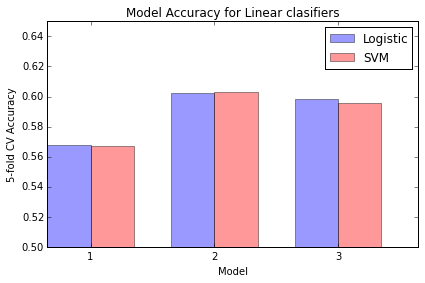

In [131]:
logistic = [0.56761094672024281, 0.60217316505038165, 0.59851841114026771]
linearsvm = [0.56698436926122708, 0.60269568548485919, 0.5960123196806959]
n_groups = 3

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, logistic, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Logistic')

rects2 = plt.bar(index + bar_width, linearsvm, bar_width,
                 alpha=opacity,
                 color='r',
                 label='SVM')

ax.set_ylim([.5,.65])

plt.xlabel('Model')
plt.ylabel('5-fold CV Accuracy')
plt.title('Model Accuracy for Linear clasifiers')
plt.xticks(index + bar_width, (1, 2, 3))
plt.legend()

plt.tight_layout()
plt.savefig('linear.pdf')
plt.show()


Confusion Matrix

In [75]:
import sklearn.metrics

In [140]:
cols = base_cols+state_cols+item_cols
m = svm.LinearSVC().fit(
    df_s[cols], 
    df_s['winner'], 
)
predicted = m.predict(df_test[cols])

In [141]:
sklearn.metrics.confusion_matrix(y_test, predicted)

array([[743, 463],
       [504, 685]])

In [142]:
cols = base_cols+state_cols+item_cols
m = sklm.LogisticRegression().fit(
    df_s[cols], 
    df_s['winner'], 
)
predicted = m.predict(df_test[cols])
sklearn.metrics.confusion_matrix(y_test, predicted)

array([[750, 456],
       [500, 689]])

Random Forest
----

Poster Computations

In [144]:
scores = []
for d in [1, 2, 3, 4, 5]:
    tree_champ_scores = skcv.cross_val_score(
        skes.AdaBoostClassifier(
            n_estimators = 200,
            base_estimator=sk.tree.DecisionTreeClassifier(max_depth=d)
        ), 
        df_s[base_cols + state_cols + item_cols],
        df_s['winner'], 
        scoring='accuracy', 
        cv=5,
        n_jobs=2)
    m = tree_champ_scores.mean()
    print(m)
    scores.append(m)

0.5827500269
0.564582824283
0.544845773218
0.535969033425
0.526991777568


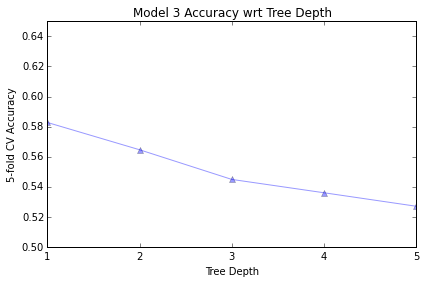

In [145]:
scores = [0.5827500269,
0.564582824283,
0.544845773218,
0.535969033425,
0.526991777568]
fig, ax = plt.subplots()

opacity = 0.4

rects1 = plt.plot([1, 2, 3, 4, 5], scores,
                  marker='^',
                  alpha=opacity,
                 label='Adaboost')

ax.set_ylim([.5,.65])

plt.xlabel('Tree Depth')
plt.ylabel('5-fold CV Accuracy')
plt.title('Model 3 Accuracy wrt Tree Depth')
plt.xticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.savefig('treedepth.pdf')
plt.show()


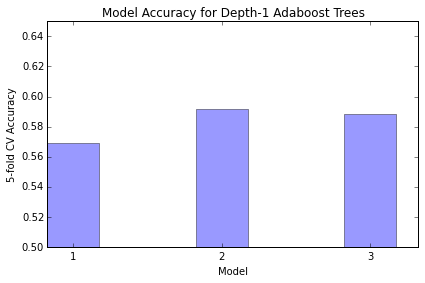

In [146]:
adaboost = [0.5692803836185758, 0.59183406378105197, 0.58807487253867152]
n_groups = 3

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, adaboost, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Adaboost')

ax.set_ylim([.5,.65])

plt.xlabel('Model')
plt.ylabel('5-fold CV Accuracy')
plt.title('Model Accuracy for Depth-1 Adaboost Trees')
plt.xticks(index + bar_width/2, (1, 2, 3))

plt.tight_layout()
plt.savefig('adaboost.pdf')
plt.show()


Generalization Error

In [164]:
cols = base_cols
m = skes.AdaBoostClassifier(
        n_estimators = 200,
        base_estimator = sk.tree.DecisionTreeClassifier(max_depth=3)
    ).fit(
    df_s[cols],
    df_s['winner']
)
print(m.score(df_s[cols], df_s['winner']))
print(m.score(df_test[cols], y_test))

0.809439281612
0.523173277662


In [165]:
cols = base_cols + state_cols
m = skes.AdaBoostClassifier(
        n_estimators = 200,
        base_estimator = sk.tree.DecisionTreeClassifier(max_depth=3)
    ).fit(
    df_s[cols],
    df_s['winner']
)
print(m.score(df_s[cols], df_s['winner']))
print(m.score(df_test[cols], y_test))

0.841077581706
0.54739039666


In [166]:
cols = base_cols + state_cols + item_cols
m = skes.AdaBoostClassifier(
        n_estimators = 200,
        base_estimator = sk.tree.DecisionTreeClassifier(max_depth=3)
    ).fit(
    df_s[cols],
    df_s['winner']
)
print(m.score(df_s[cols], df_s['winner']))
print(m.score(df_test[cols], y_test))

0.844836587658
0.560751565762


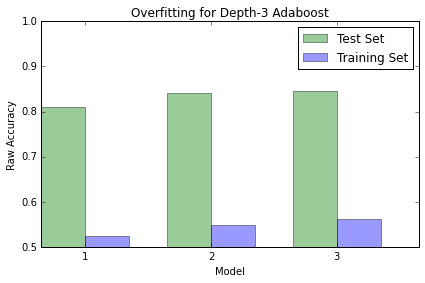

In [177]:
test = [0.809439281612, 0.841077581706, 0.844836587658]
train = [0.523173277662, 0.54739039666, 0.560751565762]
n_groups = 3

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = .4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, test, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Test Set')
rects1 = plt.bar(index+bar_width, train, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Training Set')

ax.set_ylim([.5,1])

plt.xlabel('Model')
plt.ylabel('Raw Accuracy')
plt.title('Overfitting for Depth-3 Adaboost')
plt.xticks(index + bar_width, (1, 2, 3))
plt.legend()

plt.tight_layout()
plt.savefig('adaboosttraintest.pdf')
plt.show()

Champ

In [43]:
tree_champ_scores = skcv.cross_val_score(
    skes.AdaBoostClassifier(
        n_estimators = 200,
    ), 
    df_s[base_cols],
    df_s['winner'], 
    scoring='accuracy', 
    cv=5,
    n_jobs=2)
tree_champ_scores.mean()

0.5692803836185758

In [32]:
tree_champ_scores = skcv.cross_val_score(
    skes.GradientBoostingClassifier(
        max_depth = 2,
        n_estimators = 100,
    ), 
    df_s[base_cols],
    df_s['winner'], 
    scoring='accuracy', 
    cv=5,
    n_jobs=2)
tree_champ_scores.mean()

0.5463111299747998

In [51]:
tree_champ_scores = skcv.cross_val_score(
    skes.RandomForestClassifier(
        max_depth=3,
        n_estimators=200,
        n_jobs=2,
    ), 
    df_s[base_cols],
    df_s['winner'], 
    scoring='accuracy', 
    cv=5,
    n_jobs=2)
tree_champ_scores.mean()

0.55581264969348199

Base State

In [14]:
tree_state_scores = skcv.cross_val_score(
    skes.RandomForestClassifier(
        max_depth=3,
        n_estimators=100,
        n_jobs=2,
    ), 
    df_s[base_cols + state_cols],
    df_s['winner'], 
    scoring='accuracy', 
    cv=5,
    n_jobs=-1)
tree_state_scores.mean()

0.57815587124989132

In [44]:
tree_state_scores = skcv.cross_val_score(
    skes.AdaBoostClassifier(
        n_estimators=200,
    ), 
    df_s[base_cols + state_cols],
    df_s['winner'], 
    scoring='accuracy', 
    cv=5,
    n_jobs=-1)
tree_state_scores.mean()

0.59183406378105197

In [55]:
tree_state_scores = skcv.cross_val_score(
    skes.AdaBoostClassifier(
        n_estimators=200,
        base_estimator=sk.tree.DecisionTreeClassifier(max_depth=2)
    ), 
    df_s[base_cols + state_cols],
    df_s['winner'], 
    scoring='accuracy', 
    cv=5,
    n_jobs=-1)
tree_state_scores.mean()

0.55988237691977161

In [65]:
tree_state_scores = skcv.cross_val_score(
    skes.AdaBoostClassifier(
        n_estimators=3,
        base_estimator=sk.tree.DecisionTreeClassifier(max_depth=2)
    ), 
    df_s[state_cols],
    df_s['winner'], 
    scoring='accuracy', 
    cv=5,
    n_jobs=-1)
tree_state_scores.mean()

0.57116071684424186

Dimensionality Reduction
=====

In [58]:
item_counts = df[item_cols].sum()
major_item_cols = item_counts[item_counts > 4000].axes[0].tolist()
len(major_item_cols)

33

In [71]:
base_counts = df[base_cols].sum()
major_base_cols = base_counts[base_counts > 6000].axes[0].tolist()
len(major_base_cols)

66

In [74]:
champ_scores = skcv.cross_val_score(
    sklm.LogisticRegression(), 
    df_s[major_base_cols+state_cols+major_item_cols], 
    df_s['winner'], 
    scoring='accuracy', 
    cv=5)
champ_scores.mean()

0.58744965684251527

In [27]:
tree_state_scores = skcv.cross_val_score(
    skes.RandomForestClassifier(
        max_depth=8,
        n_estimators=200,
        n_jobs=2,
    ), 
    df_s[base_cols + state_cols + item_cols],
    df_s['winner'], 
    scoring='accuracy', 
    cv=5,
    n_jobs=-1)
tree_state_scores.mean()

0.5857797847720263

In [79]:
tree_state_scores = skcv.cross_val_score(
    skes.AdaBoostClassifier(
        n_estimators=200,
    ), 
    df_s[base_cols + state_cols + item_cols],
    df_s['winner'], 
    scoring='accuracy', 
    cv=5,
    n_jobs=-1)
tree_state_scores.mean()

0.58807487253867152

In [69]:
c = skes.AdaBoostClassifier(
        n_estimators=200,
        base_estimator=sk.tree.DecisionTreeClassifier(max_depth=3)
    ).fit(df_s[base_cols + state_cols + item_cols],y_s)
print(c.score(df_test[base_cols + state_cols + item_cols], y_test))
print(c.score(df_s[base_cols + state_cols + item_cols], y_s))

0.564926931106
0.85068393025


In [68]:
c = skes.AdaBoostClassifier(
        n_estimators=200,
    ).fit(df_s[base_cols + state_cols + item_cols],y_s)
print(c.score(df_test[base_cols + state_cols + item_cols], y_test))
print(c.score(df_s[base_cols + state_cols + item_cols], y_s))

0.588308977035
0.650308029654


In [90]:
c = skes.RandomForestClassifier(
        n_estimators=200,
    ).fit(df[base_cols].iloc[1:50000],df['winner'].iloc[1:50000])
print(c.score(df[base_cols].iloc[1:50000],df['winner'].iloc[1:50000]))
print(c.score(df[base_cols].iloc[50000:],df['winner'].iloc[50000:]))

1.0
0.533993115318


In [54]:
sorted(zip(c.feature_importances_,base_cols + state_cols + item_cols))

[(0.0, 'allyc_10'),
 (0.0, 'allyc_101'),
 (0.0, 'allyc_102'),
 (0.0, 'allyc_103'),
 (0.0, 'allyc_104'),
 (0.0, 'allyc_105'),
 (0.0, 'allyc_111'),
 (0.0, 'allyc_112'),
 (0.0, 'allyc_113'),
 (0.0, 'allyc_114'),
 (0.0, 'allyc_115'),
 (0.0, 'allyc_119'),
 (0.0, 'allyc_12'),
 (0.0, 'allyc_120'),
 (0.0, 'allyc_122'),
 (0.0, 'allyc_143'),
 (0.0, 'allyc_154'),
 (0.0, 'allyc_157'),
 (0.0, 'allyc_16'),
 (0.0, 'allyc_17'),
 (0.0, 'allyc_18'),
 (0.0, 'allyc_2'),
 (0.0, 'allyc_20'),
 (0.0, 'allyc_201'),
 (0.0, 'allyc_21'),
 (0.0, 'allyc_222'),
 (0.0, 'allyc_245'),
 (0.0, 'allyc_25'),
 (0.0, 'allyc_254'),
 (0.0, 'allyc_26'),
 (0.0, 'allyc_266'),
 (0.0, 'allyc_267'),
 (0.0, 'allyc_28'),
 (0.0, 'allyc_29'),
 (0.0, 'allyc_31'),
 (0.0, 'allyc_35'),
 (0.0, 'allyc_37'),
 (0.0, 'allyc_38'),
 (0.0, 'allyc_39'),
 (0.0, 'allyc_4'),
 (0.0, 'allyc_41'),
 (0.0, 'allyc_42'),
 (0.0, 'allyc_421'),
 (0.0, 'allyc_44'),
 (0.0, 'allyc_45'),
 (0.0, 'allyc_5'),
 (0.0, 'allyc_50'),
 (0.0, 'allyc_55'),
 (0.0, 'allyc_56'),


Scratch
---------------------

In [ ]:
svmodel = sk.svm.SVC(kernel='poly')
svmodel.fit(
    df_gold[champ_cols+['gold5','gold10']+item_cols],
    df_gold['winner'], 
)

In [ ]:
champ_gold_item_scores = skcv.cross_val_score(
    sk.svm.SVC(kernel='poly'), 
    df_gold[champ_cols+['gold5','gold10']+item_cols], 
    df_gold['winner'], 
    scoring='accuracy', 
    cv=10)

In [ ]:
champ_gold_item_scores.mean()

In [ ]:
len(df_gold[df_gold['championId']==4])

In [ ]:
champ_no = 7
champ_specific_data = df_s[df_s['championId']==champ_no]
len(df_s[df_s['championId']==champ_no])

In [ ]:
scores = skcv.cross_val_score(
    sklm.LogisticRegression(), 
    champ_specific_data[champ_cols+state_cols], 
    champ_specific_data['winner'], 
    scoring='accuracy', 
    cv=10)
scores.mean()

In [ ]:
scores = skcv.cross_val_score(
    sklm.LogisticRegression(), 
    champ_specific_data[champ_cols+state_cols+item_cols], 
    champ_specific_data['winner'], 
    scoring='accuracy', 
    cv=10)
scores.mean()